In [1]:
import ROOT

Welcome to JupyROOT 6.12/06


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

In [3]:
root_dir = '/home/scanner-ml/ML-drive/Artem/share/Valerio/'

In [4]:
def get_pol_feat(id_frame, n_pol, root_dir, class_name, feat_names):
    
    f = ROOT.TFile.Open(root_dir+class_name+'/dm_tracks.dm.root','read')
    t = f.Get('Vdmr')
    all_feat = pd.DataFrame(columns=feat_names).values
    
    for pol_id in id_frame[['ViewID','pol'+str(n_pol)]].values:
        pol_feat = []
        t.GetEntry(int(pol_id[0]))
        for name in feat_names[:-1]:
            pol_feat.append(t.GetLeaf('cl.'+name).GetValue(int(pol_id[1])))
        pol_feat.append( (t.GetLeaf('cl.lx').GetValue(int(pol_id[1])))/(t.GetLeaf('cl.ly').GetValue(int(pol_id[1]))) )
        all_feat = np.vstack((all_feat, pol_feat))
    return pd.DataFrame(all_feat, columns=feat_names)

In [5]:
def stack_pols(pol_frames, feat_names):
    
    stacked = pol_frames[0].drop(feat_names, axis=1).values
    feat_array = []
    for i in range(len(pol_frames)):
        stacked = np.hstack((stacked,pol_frames[i]))
        for name in feat_names:
            feat_array.append(name+str(i))
    return pd.DataFrame(stacked, columns=feat_array)

In [6]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one feature array
    and labeling 'signal' with 1 and 'noise' with 0.
    -------
    Output:
    X - array of features
    y - array of corresponding target labels
    """
    X = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
    y = []
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = np.ones(len(idx))
        else: targ = np.zeros(len(idx))
        y = np.append(y,targ)
        X = np.vstack((X, ft_data[name].values))
    return X, y

In [7]:
feat_names = ['x','y','z','lx','ly','phi','npx','vol','eps']

In [8]:
class_names = ['C100keV', 'TestSample']

In [9]:
id_header = ['ViewID','GrainID','pol0','pol1','pol2','pol3','pol4','pol5','pol6','pol7']

In [10]:
n_pols = 8

In [11]:
pol_ids = {}
for name in class_names:
    pol_ids[name] = pd.read_csv(root_dir+name+'/bfcl_cuts_'+name+'.txt', header=None, names=id_header)

In [12]:
%%time
feat_data = {}
for name in class_names:
    pols = []
    for i in range(n_pols):
        pols.append(get_pol_feat(pol_ids[name], i, root_dir, name, feat_names))
    feat_data[name] = stack_pols(pols, feat_names)

CPU times: user 9min 18s, sys: 3.09 s, total: 9min 21s
Wall time: 9min 19s


Warning in <TClass::Init>: no dictionary for class DMRViewHeader is available
Warning in <TClass::Init>: no dictionary for class DMRAffine2D is available
Warning in <TClass::Init>: no dictionary for class DMRCluster is available
Warning in <TClass::Init>: no dictionary for class DMRGrain is available
Warning in <TClass::Init>: no dictionary for class DMRMicrotrack is available
Warning in <TClass::Init>: no dictionary for class DMRImageCl is available
Warning in <TClass::Init>: no dictionary for class DMRImage is available
Warning in <TClass::Init>: no dictionary for class DMRFrame is available


In [13]:
copa = feat_data['C100keV']
for i in range(n_pols):
    copa = copa[ copa['lx'+str(i)]<1000 ]
feat_data['C100keV'] = copa

In [14]:
topa = feat_data['TestSample']
for i in range(n_pols):
    topa = topa[ topa['lx'+str(i)]<1000 ]
feat_data['TestSample'] = topa

In [15]:
X, y = feat_to_input(feat_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [16]:
X_train.shape

(18542, 72)

### Training

In [17]:
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.9010526315789473


In [18]:
feat_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y4', 'y7', 'y1', 'y0', 'y5', 'x4', 'x0', 'y6', 'x3', 'x2', 'y2', 'x1',
       'y3', 'x6', 'x5', 'x7', 'ly5', 'eps4', 'phi7', 'phi3', 'phi6', 'phi5',
       'phi1', 'eps2', 'eps3', 'phi0', 'eps5', 'eps1', 'ly0', 'ly7', 'phi2',
       'ly4', 'phi4', 'ly2', 'ly3', 'lx3', 'ly1', 'eps6', 'ly6', 'lx2', 'lx5',
       'lx4', 'lx1', 'eps0', 'eps7', 'lx6', 'lx7', 'lx0', 'npx2', 'vol6',
       'vol0', 'vol2', 'vol7', 'npx5', 'vol1', 'npx7', 'npx6', 'npx3', 'npx0',
       'npx4', 'npx1', 'vol3', 'vol5', 'vol4', 'z0', 'z1', 'z2', 'z5', 'z6',
       'z4', 'z3', 'z7'],
      dtype='object')

* Dropping unphysical 'z'

In [19]:
feat_noz_data = {}
for name in class_names:
    copa = feat_data[name]
    for i in range(n_pols):
        copa = copa.drop(['z'+str(i)],axis=1)
    feat_noz_data[name] = copa

In [20]:
X, y = feat_to_input(feat_noz_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [21]:
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.8351001177856302


In [22]:
feat_noz_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y1', 'x3', 'y0', 'x5', 'y5', 'y3', 'y2', 'x1', 'x0', 'y4', 'x2', 'x6',
       'y6', 'y7', 'x7', 'x4', 'eps2', 'phi1', 'phi3', 'eps1', 'phi2', 'phi0',
       'lx2', 'eps5', 'eps4', 'ly0', 'eps3', 'phi7', 'phi4', 'ly7', 'lx1',
       'phi5', 'phi6', 'ly6', 'lx3', 'eps0', 'ly2', 'eps6', 'lx4', 'lx5',
       'eps7', 'ly5', 'ly4', 'ly1', 'ly3', 'lx6', 'lx7', 'lx0', 'vol7', 'vol0',
       'npx6', 'npx7', 'vol5', 'vol3', 'npx0', 'vol6', 'vol2', 'npx1', 'npx5',
       'npx4', 'vol1', 'npx3', 'npx2', 'vol4'],
      dtype='object')

### Performance without directionallity

In [23]:
feat_noz_nophi_data = {}
for name in class_names:
    copa = feat_noz_data[name]
    for i in range(n_pols):
        copa = copa.drop(['phi'+str(i)],axis=1)
    feat_noz_nophi_data[name] = copa

In [24]:
X, y = feat_to_input(feat_noz_nophi_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [25]:
%%time
randcla = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.8336086853906065
CPU times: user 2min 20s, sys: 303 ms, total: 2min 21s
Wall time: 13.1 s


In [26]:
feat_noz_nophi_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y7', 'y3', 'y2', 'y4', 'y1', 'y0', 'y5', 'x0', 'y6', 'x7', 'x6', 'x1',
       'x3', 'x4', 'x2', 'x5', 'eps1', 'eps2', 'lx2', 'eps3', 'eps4', 'ly0',
       'lx3', 'eps5', 'ly7', 'ly6', 'ly2', 'eps0', 'lx1', 'ly5', 'ly1', 'eps6',
       'lx4', 'eps7', 'lx5', 'ly3', 'ly4', 'lx7', 'lx6', 'lx0', 'npx6', 'vol6',
       'vol7', 'vol2', 'npx5', 'npx2', 'vol1', 'vol0', 'vol5', 'npx7', 'npx1',
       'npx4', 'npx3', 'npx0', 'vol4', 'vol3'],
      dtype='object')

In [27]:
roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1])

0.8513613473851313

In [28]:
%%time
boocla = GradientBoostingClassifier(n_estimators=1000)
boocla.fit(X_train, y_train)
print(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))

0.8523446056699686
CPU times: user 1min 21s, sys: 47.4 ms, total: 1min 21s
Wall time: 1min 21s


* 10000

In [29]:
%%time
randcla = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
randcla.fit(X_train, y_train)
print(roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1]))

0.8518075480740132
CPU times: user 23min 30s, sys: 2.56 s, total: 23min 33s
Wall time: 2min 9s


In [30]:
%%time
boocla = GradientBoostingClassifier(n_estimators=10000)
boocla.fit(X_train, y_train)
print(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))

0.8375258786726573
CPU times: user 13min 21s, sys: 691 ms, total: 13min 22s
Wall time: 13min 20s


### No volume

In [31]:
feat_noz_novol_data = {}
for name in class_names:
    copa = feat_noz_data[name]
    for i in range(n_pols):
        copa = copa.drop(['vol'+str(i)],axis=1)
    feat_noz_novol_data[name] = copa

In [32]:
X, y = feat_to_input(feat_noz_novol_data, class_names)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [33]:
%%time
randcla = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
randcla.fit(X_train, y_train)
print ('precision ', precision_score(y_test, randcla.predict(X_test)))

precision  0.8354755784061697
CPU times: user 2min 22s, sys: 300 ms, total: 2min 22s
Wall time: 13.3 s


In [34]:
feat_noz_novol_data['C100keV'].columns[np.argsort(randcla.feature_importances_)]

Index(['y5', 'y6', 'y0', 'y1', 'y7', 'y2', 'y3', 'y4', 'x6', 'x7', 'x4', 'x1',
       'x2', 'x5', 'x3', 'x0', 'eps1', 'eps2', 'phi2', 'phi4', 'phi0', 'phi3',
       'phi7', 'phi1', 'phi5', 'eps3', 'phi6', 'lx2', 'lx1', 'eps4', 'eps5',
       'ly7', 'eps6', 'ly0', 'lx3', 'ly6', 'eps7', 'eps0', 'ly5', 'lx5', 'lx4',
       'lx7', 'lx6', 'ly2', 'ly1', 'lx0', 'ly3', 'ly4', 'npx7', 'npx6', 'npx5',
       'npx2', 'npx1', 'npx0', 'npx3', 'npx4'],
      dtype='object')

In [35]:
roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1])

0.8466665997731754

# Multi-run plot

In [36]:
%%time
n_est = [50, 100, 500, 1000, 5000, 10000]
boo_aucs = pd.DataFrame(columns=n_est).values
rand_aucs = pd.DataFrame(columns=n_est).values
for run in range(50):
    X, y = feat_to_input(feat_noz_nophi_data, class_names)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=(145*run))
    boo_rocs = []
    rand_rocs = []
    for n in n_est:
        boocla.set_params(n_estimators=n)
        boocla.fit(X_train, y_train)
        boo_rocs.append(roc_auc_score(y_test, boocla.predict_proba(X_test)[:,1]))
        
        randcla.set_params(n_estimators=n)
        randcla.fit(X_train, y_train)
        rand_rocs.append(roc_auc_score(y_test, randcla.predict_proba(X_test)[:,1]))
        
    print('boo ',boo_rocs ,'\nrand ', rand_rocs)
    boo_aucs = np.vstack((boo_aucs, boo_rocs))
    rand_aucs = np.vstack((rand_aucs, rand_rocs))


boo  [0.8418463827341731, 0.8450549906069581, 0.8472179845594294, 0.8465959175938923, 0.841855406371026, 0.8399624165525084] 
rand  [0.8412548410401772, 0.8432947469462039, 0.8454799475049926, 0.846445335653912, 0.847122742892335, 0.8471651116872453]
boo  [0.8403995097065522, 0.8434983976905557, 0.8487002478503451, 0.8482435289651641, 0.838419038128785, 0.8353527729222946] 
rand  [0.841221700257782, 0.8458124078561717, 0.8480078587098541, 0.8488379118332539, 0.8493696010337765, 0.8493704976428837]
boo  [0.8417976759416448, 0.8452070747790592, 0.8492892559040418, 0.8476597776208672, 0.8368017823270741, 0.8337521790829183] 
rand  [0.8449342199342199, 0.8465319126797726, 0.8505498272035237, 0.850875263813007, 0.8508916782263085, 0.8511489532890312]
boo  [0.8554820532654357, 0.8594765227116847, 0.8606929222369424, 0.860653624262739, 0.8520569803662797, 0.8487538301388886] 
rand  [0.853737746241389, 0.8562328848840766, 0.8593630109372765, 0.8602445295240874, 0.8604695740382315, 0.8606052085

boo  [0.846352063436864, 0.8486727426563511, 0.8531054877827484, 0.8526798651657883, 0.8426285087797699, 0.8385754114442243] 
rand  [0.8475214084249173, 0.8498129725115228, 0.8539173260228621, 0.8537513697654376, 0.8541094181902684, 0.8540033849388906]
boo  [0.8400639928262819, 0.8449661693975707, 0.8468631287193282, 0.8438557376158256, 0.8338000326078097, 0.8294444444444445] 
rand  [0.8416750224178691, 0.8432759300019022, 0.84706679166327, 0.8477164343360235, 0.8479563055351758, 0.8480614657210401]
boo  [0.8467392820097992, 0.8495938200196562, 0.850757469272604, 0.8493193665792378, 0.8405906082477148, 0.8363113013148764] 
rand  [0.8405163002565084, 0.8452694421650486, 0.8487355279978621, 0.8494263145291985, 0.8497042403056545, 0.8497699369034873]
boo  [0.8309341026955601, 0.8359009457302519, 0.8381510621733589, 0.836647075183712, 0.8319418800898484, 0.8289414455923072] 
rand  [0.8319394367392802, 0.8335195864566334, 0.8376147816286845, 0.8391036896548257, 0.8388428794341926, 0.8388681

In [37]:
boo_means = boo_aucs.mean(axis=0)
rand_means = rand_aucs.mean(axis=0)
boo_vars = boo_aucs.var(axis=0)
rand_vars = rand_aucs.var(axis=0)

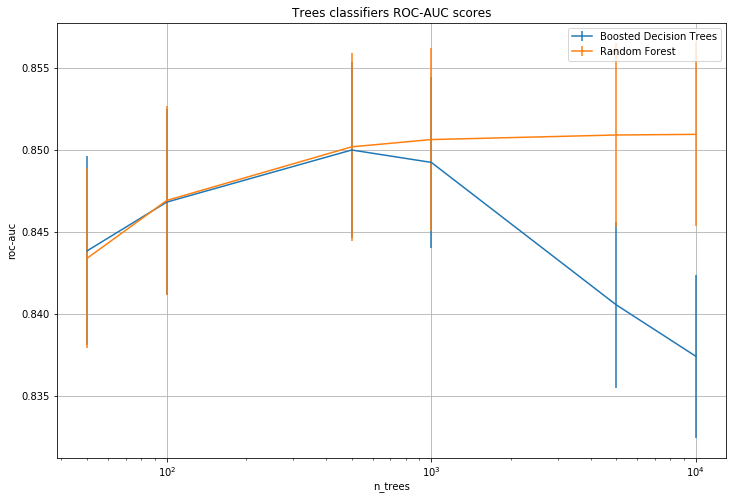

In [41]:
#plot
plt.figure(figsize=(12,8))
plt.errorbar(n_est, boo_means, yerr=np.sqrt(np.array(boo_vars, dtype=float)), label='Boosted Decision Trees')
plt.errorbar(n_est, rand_means, yerr=np.sqrt(np.array(rand_vars, dtype=float)), label='Random Forest')
plt.title('Trees classifiers ROC-AUC scores')
plt.ylabel('roc-auc')
plt.xlabel('n_trees')
plt.xscale('log')
plt.grid()
plt.legend()
plt.savefig('trees.pdf')

# 51. TESTING AREA

In [ ]:
feat_data['TestSample']['phi0'].hist()

In [3]:
f = ROOT.TFile.Open('/home/artem145/NEWS/root_files/Valerio/TestSample/dm_tracks.dm.root','read')

Warning in <TClass::Init>: no dictionary for class DMRViewHeader is available
Warning in <TClass::Init>: no dictionary for class DMRAffine2D is available
Warning in <TClass::Init>: no dictionary for class DMRCluster is available
Warning in <TClass::Init>: no dictionary for class DMRGrain is available
Warning in <TClass::Init>: no dictionary for class DMRMicrotrack is available
Warning in <TClass::Init>: no dictionary for class DMRImageCl is available
Warning in <TClass::Init>: no dictionary for class DMRImage is available
Warning in <TClass::Init>: no dictionary for class DMRFrame is available


In [4]:
t = f.Get('Vdmr')

In [79]:
t.GetEntry(0)

480528

In [80]:
t.GetLeaf('cl.ly').GetValue(1027)

0.1619206815958023

In [107]:
copa = pd.read_csv(root_dir+'TestSample/yandex_bfcl_TestSample.txt').drop(['emp'],axis=1)
copa.head(10)

,ViewID,GrainID,pol0,pol1,pol2,pol3,pol4,pol5,pol6
0,0,0,2128,2137,2147,2156,2163,2171,2177
1,0,4,2333,2337,2340,2343,2348,2349,2352
2,0,6,2533,2537,2538,2541,2544,2546,2548
3,0,19,1718,1719,1720,1721,1722,1713,1723
4,0,24,1658,1659,1661,1662,1663,1664,1665
5,0,28,1588,1589,1591,1594,1596,1598,1600
6,0,38,1481,1484,1486,1458,1460,1462,1465
7,0,39,2457,2459,2461,2446,2448,2450,2451
8,0,41,1538,1540,1542,1543,1544,1545,1547
9,0,57,1317,1321,1322,1324,1326,1328,1331


In [128]:
%%time
pols = []
for i in range(7):
    pols.append(get_pol_feat(copa, i, root_dir, 'TestSample', feat_names))
feat_data = stack_pols(pols, feat_names)

CPU times: user 1min 45s, sys: 3.38 s, total: 1min 49s
Wall time: 1min 49s


In [130]:
feat_data.head(5)

,x0,y0,z0,lx0,ly0,phi0,npx0,vol0,x1,y1,...,npx5,vol5,x6,y6,z6,lx6,ly6,phi6,npx6,vol6
0,20.7725,-15.9359,-22.95,0.181091,0.14048,0.267327,39,316,20.7633,-15.9407,...,45,355,20.7716,-15.9525,-22.95,0.187638,0.144514,0.395403,46,418
1,20.2258,22.9718,-23.95,0.737818,0.32068,0.608326,172,10548,20.2259,22.9667,...,37,415,20.5057,23.1455,-23.95,0.544898,0.303975,2.50439,27,268
2,20.0909,22.9088,-23.15,0.427617,0.215545,1.59147,60,1571,20.097,22.8952,...,9,236,20.2524,23.0559,-23.2,0.0688121,0.0688121,0,5,102
3,27.2961,22.7063,-15.2,0.163098,0.146182,0.81736,28,147,27.2934,22.712,...,6,16,27.296,22.6969,-15.25,0.209391,0.152747,3.04847,23,87
4,31.0651,16.1804,-12.95,0.288794,0.192397,2.89978,62,624,31.0564,16.1784,...,55,430,31.0325,16.1644,-13,0.257539,0.183618,3.04189,66,572


In [87]:
t.GetLeaf('cl.ly').GetValue(2533)

0.2155449092388153

In [106]:
t.GetLeaf('cl.ly').GetValue(int(coco))

0.14048033952713013

In [18]:
ROOT.gROOT.ProcessLine("2*sin(2.1*4.0)")

1

(double) 1.7091978


In [6]:
ROOT.gROOT.ProcessLine("struct staff_t { Float_t cl_x; TBranch b_cl_x; }" )

0

In [9]:
toto = ROOT.staff_t()
t.SetBranchAddress('cl.x', ROOT.AddressOf(toto,'cl_x'))

4